In [11]:
import os
import cv2
import torch
import numpy as np
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import torch.nn.functional as F
from sklearn.metrics import jaccard_score
import matplotlib.pyplot as plt
from PIL import Image
import time
import torchvision.models.segmentation
from tqdm import tqdm

# Define the color palette
palette = [
    (0, 0, 0),
    (230, 25, 75),
    (60, 180, 75),
    (255, 225, 25),
    (0, 130, 200),
    (145, 30, 180),
    (70, 240, 240),
    (240, 50, 230),
    (210, 245, 60),
    (230, 25, 75),
    (0, 128, 128),
    (170, 110, 40),
    (255, 250, 200),
    (128, 0, 0),
    (170, 255, 195),
    (128, 128, 0),
    (250, 190, 190),
    (0, 0, 128),
    (128, 128, 128),
]

color_to_gray = {color: i for i, color in enumerate(palette)}

def transform(mode):
    if mode == 'train':
        return transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize(size=(128, 128)),
            transforms.ToTensor()
        ])
    elif mode == 'test':
        return transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize(size=(128, 128)),
            transforms.ToTensor()
        ])

class CustomDataset(Dataset):
    def __init__(self, img_dir, label_dir, trans=None):
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.transform = trans
        self.img_names = os.listdir(img_dir)
        self.label_names = os.listdir(label_dir)
        
        assert len(self.img_names) == len(self.label_names), "Mismatch between image and label count"
        
        self.img_names.sort()
        self.label_names.sort()
        
        self.palette = palette
        self.color_to_class = color_to_gray

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        img_name = self.img_names[idx]
        label_name = self.label_names[idx]

        img_path = os.path.join(self.img_dir, img_name)
        label_path = os.path.join(self.label_dir, label_name)

        image = cv2.imread(img_path)
        label = Image.open(label_path).convert('RGB')
        label = np.array(label)
        
        label_gray = np.zeros((label.shape[0], label.shape[1]), dtype=np.uint8)
        
        for color, class_idx in self.color_to_class.items():
            mask = np.all(label == color, axis=-1)
            label_gray[mask] = class_idx
        
        label_gray = cv2.resize(label_gray, (128, 128), interpolation=cv2.INTER_NEAREST)
        
        if self.transform:
            image = self.transform(image)
        
        label_gray = torch.tensor(label_gray, dtype=torch.long)  # Convert to tensor

        return image, label_gray



In [12]:
dataset = CustomDataset(img_dir='dataset', label_dir='label_set', trans=transform('train'))

(128, 128, 3)
(128, 128)


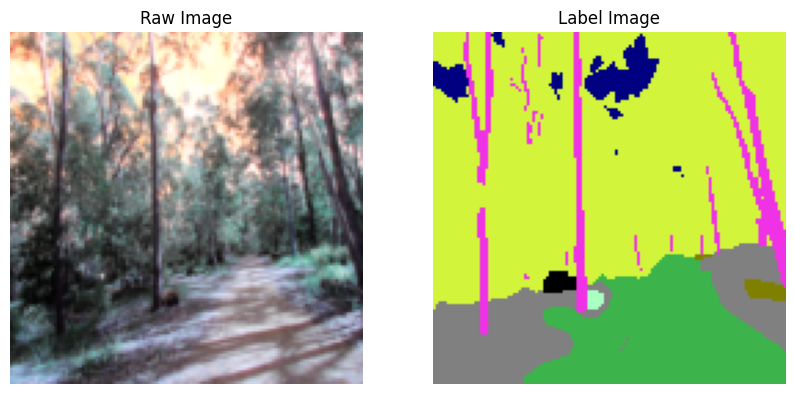

In [13]:
index = 1
image, label = dataset[index]

image_np = image.permute(1, 2, 0).numpy()
print(image_np.shape)
label_np = label.numpy()
print(label_np.shape)

# Create a class_to_color dictionary
class_to_color = {idx: color for idx, color in enumerate(dataset.palette)}

def class_idx_to_rgb(label, class_to_color):
    rgb_label = np.zeros((label.shape[0], label.shape[1], 3), dtype=np.uint8)
    for class_idx, color in class_to_color.items():
        mask = label == class_idx
        rgb_label[mask] = np.array(color)
    return rgb_label

label_rgb = class_idx_to_rgb(label_np, class_to_color)

# Visualize the images
plt.figure(figsize=(10, 5))

# Plot the raw image
plt.subplot(1, 2, 1)
plt.imshow(image_np)
plt.title('Raw Image')
plt.axis('off')

# Plot the label image
plt.subplot(1, 2, 2)
plt.imshow(label_rgb)
plt.title('Label Image')
plt.axis('off')

plt.show()


In [14]:
def create_data_loaders(img_dir, label_dir, batch_size, train_val_split):
    dataset = CustomDataset(img_dir=img_dir, label_dir=label_dir, trans=transform('train'))
    dataset_len = len(dataset)
    # print(dataset_len)
    train_len = int(train_val_split * dataset_len)
    val_len = dataset_len - train_len
    train_subset, val_subset = random_split(dataset, [train_len, val_len])
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
    return train_loader, val_loader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# net = Unet().to(device)
# criterion = SegmentationLoss()
# optimiser = optim.Adam(net.parameters(), lr=0.001)
batch_size = 32
# epochs = 10

In [15]:
train_loader, val_loader = create_data_loaders('dataset', 'label_set', batch_size, 0.8)

In [16]:
model = torchvision.models.segmentation.deeplabv3_resnet101(pretrained=True)

# Modify the final classification layer
model.classifier[4] = nn.Conv2d(256, 19, kernel_size=(1, 1), stride=(1, 1))

# Move model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

model

checkpoint_path = f'./resnet_chkpoint_local.pt'
best_model_path = f'./resnet_bestmodellocal.pt'
epochs = 10
criterion = nn.CrossEntropyLoss()
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
valid_loss_min = float('inf')

def save_ckp(state, is_best, checkpoint_path, best_model_path):
    torch.save(state, checkpoint_path)
    if is_best:
        torch.save(state, best_model_path)

train_loss,val_loss = [],[]
train_iou,val_iou = [],[]

def iou_batch(preds, labels):
    preds = torch.argmax(preds, dim=1)
    preds = preds.view(-1).cpu().numpy()
    labels = labels.view(-1).cpu().numpy()
    return jaccard_score(labels, preds, average='macro')

# Training and validation loop
for epoch in range(epochs):
    print('Epoch {}/{}'.format(epoch + 1, epochs))
    start_time = time.time()

    running_train_loss = []
    running_train_score = []

    model.train()
    for image, mask in tqdm(train_loader, desc='Training Batches'):  # Add tqdm for training
        image = image.to(device, dtype=torch.float)
        mask = mask.to(device, dtype=torch.long)
        # print(image.shape)
        pred_mask = model(image)['out']
        loss = criterion(pred_mask, mask)
        score = iou_batch(pred_mask, mask)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_train_loss.append(loss.item())
        running_train_score.append(score)

    model.eval()
    running_val_loss = []
    running_val_score = []
    with torch.no_grad():
        for image, mask in tqdm(val_loader, desc='Validation Batches'):  # Add tqdm for validation
            image = image.to(device, dtype=torch.float)
            mask = mask.to(device, dtype=torch.long)

            pred_mask = model(image)['out']
            loss = criterion(pred_mask, mask)
            score = iou_batch(pred_mask, mask)

            running_val_loss.append(loss.item())
            running_val_score.append(score)

    epoch_train_loss = np.mean(running_train_loss)
    epoch_train_score = np.mean(running_train_score)
    print('Train loss : {} iou : {}'.format(epoch_train_loss, epoch_train_score))
    # print('Train loss : {}'.format(epoch_train_loss))

    train_loss.append(epoch_train_loss)
    train_iou.append(epoch_train_score)

    epoch_val_loss = np.mean(running_val_loss)
    epoch_val_score = np.mean(running_val_score)
    print('Validation loss : {} iou : {}'.format(epoch_val_loss, epoch_val_score))
    # print('Validation loss : {}'.format(epoch_val_loss))
    val_loss.append(epoch_val_loss)
    val_iou.append(epoch_val_score)

    checkpoint = {
            'epoch': epoch + 1,
            'valid_loss_min': epoch_val_loss,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
    }

    save_ckp(checkpoint, False, checkpoint_path, best_model_path)
    if epoch_val_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min, epoch_val_loss))
            save_ckp(checkpoint, True, checkpoint_path, best_model_path)
            valid_loss_min = epoch_val_loss

    time_elapsed = time.time() - start_time
    print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

Epoch 1/10


Validation Batches: 100%|█████████████████████████| 11/11 [08:50<00:00, 48.20s/it]


Train loss : 1.2090108489448375 iou : 0.15265489240192798
Validation loss : 0.7186202515255321 iou : 0.18402364091640405
Validation loss decreased (inf --> 0.718620).  Saving model ...
48m 2s
Epoch 2/10


Validation Batches: 100%|█████████████████████████| 11/11 [07:30<00:00, 40.96s/it]


Train loss : 0.6609588278965517 iou : 0.22034967810034561
Validation loss : 0.7503311850807883 iou : 0.18463673053364235
48m 17s
Epoch 3/10


Validation Batches: 100%|█████████████████████████| 11/11 [07:32<00:00, 41.17s/it]


Train loss : 0.582944817841053 iou : 0.2620595729866018
Validation loss : 0.5721923465078528 iou : 0.2690360495824893
Validation loss decreased (0.718620 --> 0.572192).  Saving model ...
48m 30s
Epoch 4/10


Validation Batches: 100%|█████████████████████████| 11/11 [08:34<00:00, 46.79s/it]


Train loss : 0.5476798957044428 iou : 0.28654645058441663
Validation loss : 0.5870827815749429 iou : 0.2681236990885227
47m 11s
Epoch 5/10


Validation Batches: 100%|█████████████████████████| 11/11 [07:45<00:00, 42.34s/it]


Train loss : 0.5131865346973593 iou : 0.30301493568076
Validation loss : 0.5423410805788907 iou : 0.27516519840047604
Validation loss decreased (0.572192 --> 0.542341).  Saving model ...
44m 49s
Epoch 6/10


Validation Batches: 100%|█████████████████████████| 11/11 [07:27<00:00, 40.66s/it]


Train loss : 0.4925754171880809 iou : 0.3118322260553285
Validation loss : 0.5404283810745586 iou : 0.2921614878369977
Validation loss decreased (0.542341 --> 0.540428).  Saving model ...
45m 18s
Epoch 7/10


Validation Batches: 100%|█████████████████████████| 11/11 [07:24<00:00, 40.44s/it]


Train loss : 0.46306938407095993 iou : 0.3479940562843224
Validation loss : 0.5230727439576929 iou : 0.31160243666514
Validation loss decreased (0.540428 --> 0.523073).  Saving model ...
44m 53s
Epoch 8/10


Validation Batches: 100%|█████████████████████████| 11/11 [07:27<00:00, 40.66s/it]


Train loss : 0.44069432670419867 iou : 0.36776810622400613
Validation loss : 0.5144937417723916 iou : 0.3216493534041733
Validation loss decreased (0.523073 --> 0.514494).  Saving model ...
42m 59s
Epoch 9/10


Validation Batches: 100%|█████████████████████████| 11/11 [07:52<00:00, 42.97s/it]


Train loss : 0.4258846484801986 iou : 0.39304659545762777
Validation loss : 0.5338241024450823 iou : 0.3393233302390279
44m 8s
Epoch 10/10


Validation Batches: 100%|█████████████████████████| 11/11 [07:47<00:00, 42.51s/it]


Train loss : 0.41454934802922333 iou : 0.4077989700077033
Validation loss : 0.5154793181202628 iou : 0.36465635273345404
43m 37s
